In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# Exercises
file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

## Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [2]:
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)

In [3]:
data.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
df = pd.read_fwf('anonymized-curriculum-access.txt')

In [5]:
data['date'] = data[0] + ' ' + data[1]

In [6]:
df.head()

,2018-01-26,09:55:03,/ 1 8 97.105.19.61,Unnamed: 3
0,2018-01-26,09:56:02,java-ii 1 8 97.105.19.61,NaN
1,2018-01-26,09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN
2,2018-01-26,09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN
3,2018-01-26,09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN
4,2018-01-26,09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN


In [7]:
data = data.drop(columns = [0,1])

In [8]:
data.head()

,2,3,4,5,date
0,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [9]:
data = data.rename(columns={2: "page", 3:'user_id', 4:'cohort_id', 5:'ip'})

In [10]:
data.head()

,page,user_id,cohort_id,ip,date
0,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [11]:
data.date = pd.to_datetime(data.date)
df = data.set_index('date')

In [12]:
df.value_counts()

page                             user_id  cohort_id  ip            
/                                11       28.0       97.105.19.58      571
index.html                       53       14.0       97.105.19.58      501
toc                              632      57.0       136.50.74.48      377
index.html                       53       28.0       67.10.174.56      351
/                                1        28.0       97.105.19.58      345
                                                                      ... 
java-iii/jdbc                    634      57.0       104.190.242.24      1
                                 637      57.0       192.119.10.210      1
                                 648      56.0       76.187.53.87        1
                                 656      58.0       24.9.177.142        1
%20https://github.com/RaulCPena  580      55.0       74.192.167.159      1
Length: 148229, dtype: int64

In [13]:
len(df.ip.value_counts())

4339

In [14]:
len(df.cohort_id.value_counts())

40

In [15]:
len(df.user_id.value_counts())

787

In [16]:
df.groupby(['user_id','ip']).count()

page  cohort_id
user_id ip                             
1       12.5.63.210        6          6
        172.56.15.15       8          8
        172.56.15.203      3          3
        172.56.15.46       1          1
        172.56.15.50       2          2
...                      ...        ...
784     99.43.143.116     93         93
785     24.173.208.242     1          1
        72.181.127.233    30         30
786     72.190.25.232      7          7
787     99.126.113.140     1          1

[6182 rows x 2 columns]

In [17]:
df.groupby(['cohort_id','ip']).count()

page  user_id
cohort_id ip                           
1.0       107.204.49.22      1        1
          107.77.196.213     9        9
          107.77.217.196     3        3
          107.77.217.65      7        7
          107.77.220.6       1        1
...                        ...      ...
62.0      98.199.170.30      2        2
          98.39.66.72       24       24
          99.151.201.25    254      254
          99.162.243.68    126      126
          99.5.223.96        4        4

[4605 rows x 2 columns]

In [18]:
df.groupby(['page','ip']).count()

user_id  cohort_id
page                             ip                                
%20https://github.com/RaulCPena  74.192.167.159        1          1
,%20https://github.com/RaulCPena 74.192.167.159        1          1
.git                             72.178.123.71         1          1
.gitignore                       72.178.123.71         1          1
.well-known/assetlinks.json      70.240.251.44         2          2
...                                                  ...        ...
working-with-time-series-data    72.181.127.233        4          4
                                 75.1.166.163          1          1
                                 96.8.130.213          2          2
wp-admin                         70.121.163.5          1          1
wp-login                         70.121.163.5          1          1

[90364 rows x 2 columns]

In [19]:
df.groupby(['page','cohort_id']).count()

user_id  ip
page                             cohort_id             
%20https://github.com/RaulCPena  55.0             1   1
,%20https://github.com/RaulCPena 55.0             1   1
.git                             24.0             1   1
.gitignore                       24.0             1   1
.well-known/assetlinks.json      58.0             2   2
...                                             ...  ..
web-dev-day-two                  61.0             2   2
working-with-time-series-data    28.0             1   1
                                 59.0            14  14
wp-admin                         22.0             1   1
wp-login                         22.0             1   1

[11780 rows x 2 columns]

In [20]:
df.head()

,page,user_id,cohort_id,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [21]:
cohort_df = df.drop(columns = ['user_id','ip'])

In [22]:
cohort_df.head()

,page,cohort_id
date,,
2018-01-26 09:55:03,/,8.0
2018-01-26 09:56:02,java-ii,8.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,8.0
2018-01-26 09:56:06,slides/object_oriented_programming,8.0
2018-01-26 09:56:24,javascript-i/conditionals,22.0


In [23]:
cohort_df.page.str.contains('java').value_counts()

False    458828
True     260630
Name: page, dtype: int64

In [24]:
len(cohort_df.page.unique())

2154

In [25]:
cohort_df.page.str.contains('classification')

date
2018-01-26 09:55:03    False
2018-01-26 09:56:02    False
2018-01-26 09:56:05    False
2018-01-26 09:56:06    False
2018-01-26 09:56:24    False
                       ...  
2020-11-02 16:48:13    False
2020-11-02 16:48:17    False
2020-11-02 16:48:18    False
2020-11-02 16:48:28    False
2020-11-02 16:48:47    False
Name: page, Length: 719459, dtype: object

In [41]:
mask = df.page.str.contains('classification') | df.page.str.contains('regression') | df.page.str.contains('clustering') | df.page.str.contains('anomaly') | df.page.str.contains('data-science') | df.page.str.contains('python')

In [42]:
mask.value_counts()

False    681945
True      37514
Name: page, dtype: int64

In [27]:
#df[df == mask]

In [46]:
train = df[:'2019-12-31']
validate = df['2020-01-01':'2020-06-01']
test = df['2020-06-02':]

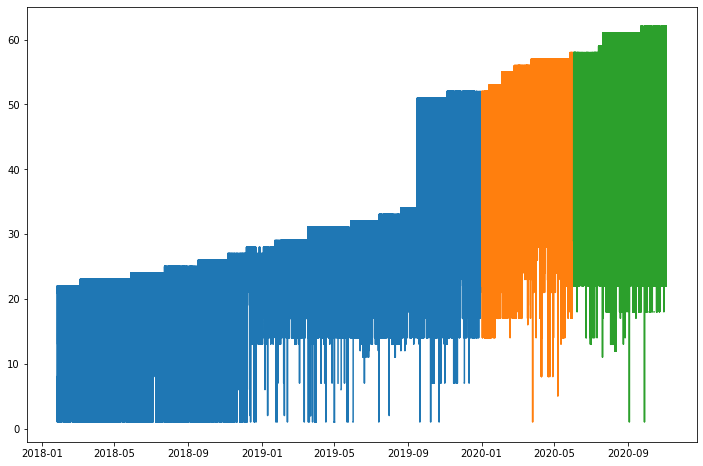

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(train.cohort_id)
plt.plot(validate.cohort_id)
plt.plot(test.cohort_id)
plt.show()

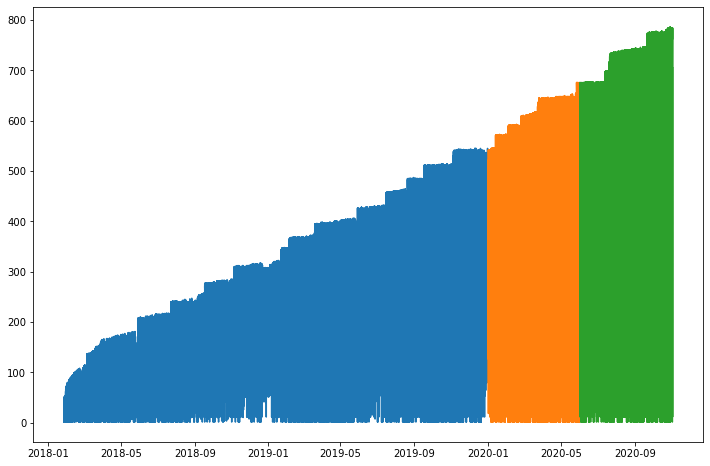

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(train.user_id)
plt.plot(validate.user_id)
plt.plot(test.user_id)
plt.show()

In [53]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()
short_rolling

,user_id,cohort_id
date,,
2018-01-26 09:55:03,NaN,NaN
2018-01-26 09:56:02,NaN,NaN
2018-01-26 09:56:05,NaN,NaN
2018-01-26 09:56:06,NaN,NaN
2018-01-26 09:56:24,NaN,NaN
...,...,...
2019-12-31 15:44:41,451.833333,31.666667
2019-12-31 15:44:41,454.500000,31.166667
2019-12-31 17:41:42,465.500000,32.583333


### Looking at the pages accessed to see if maybe there is something that stands out

Text(0.5, 1.0, 'Total pages requested per day')

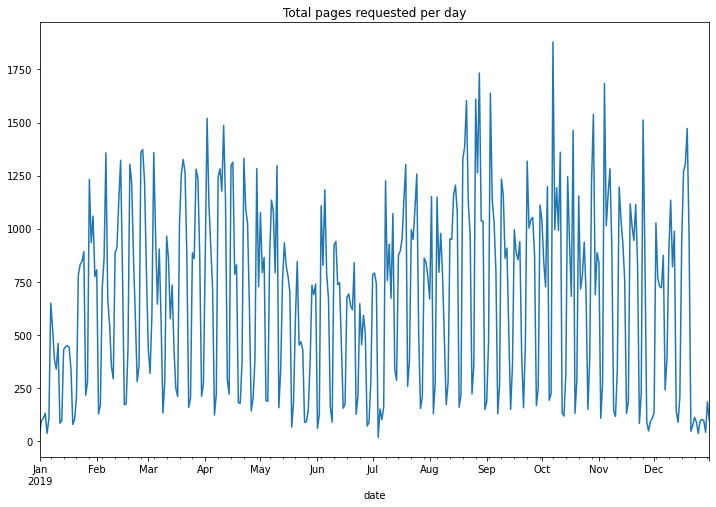

In [57]:
df["2019"].groupby("date").page.count().resample("D").sum().plot.line(figsize=(12, 8))
plt.title("Total pages requested per day")

### Cohort activity

In [59]:
curie = df[df.cohort_id == 55]

In [61]:
curie

,page,user_id,cohort_id,ip
date,,,,
2020-02-03 15:39:34,login,575,55.0,97.105.19.58
2020-02-03 15:39:35,/,576,55.0,97.105.19.58
2020-02-03 15:39:37,/,577,55.0,97.105.19.58
2020-02-03 15:39:37,login,575,55.0,97.105.19.58
2020-02-03 15:39:43,/,578,55.0,97.105.19.58
...,...,...,...,...
2020-11-02 15:33:20,search/search_index.json,581,55.0,70.112.179.142
2020-11-02 15:33:27,advanced-topics/cross-validation,581,55.0,70.112.179.142
2020-11-02 15:57:22,/,616,55.0,70.114.9.241


In [28]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [29]:
compute_entropy(df.user_id)

6.170031470548415

In [30]:
compute_entropy(df.cohort_id)

3.9027926786187983

In [31]:
compute_entropy(df.ip)

4.281933437860451